In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [3]:
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [4]:
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data = read_text("/content/drive/MyDrive/archive/afr.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [7]:
print(data)

Come in.	Gaan binne.	CC-BY 2.0 (France) Attribution: tatoeba.org #348091 (Hertz) & #2783902 (Diablofire)
She runs.	Sy hardloop.	CC-BY 2.0 (France) Attribution: tatoeba.org #672264 (CM) & #672267 (winterstream)
You lost.	Jy verloor.	CC-BY 2.0 (France) Attribution: tatoeba.org #6440636 (CK) & #6456479 (Dewald)
Go inside.	Gaan binne.	CC-BY 2.0 (France) Attribution: tatoeba.org #2428954 (CK) & #2783902 (Diablofire)
Look back.	Kyk agter jou.	CC-BY 2.0 (France) Attribution: tatoeba.org #2111609 (CK) & #5507226 (CJuser01)
He is poor.	Hy is arm.	CC-BY 2.0 (France) Attribution: tatoeba.org #516601 (kebukebu) & #6007351 (CJuser01)
I eat rice.	Ek eet rys.	CC-BY 2.0 (France) Attribution: tatoeba.org #7073209 (azraelgnosis) & #5930641 (CJuser01)
Tom is wet.	Tom is nat.	CC-BY 2.0 (France) Attribution: tatoeba.org #2236921 (CK) & #5532438 (CJuser01)
We all lie.	Ons almal lieg.	CC-BY 2.0 (France) Attribution: tatoeba.org #6440635 (CK) & #6456480 (Dewald)
I'm thirsty.	Ek is dors.	CC-BY 2.0 (France) Att

In [8]:
deu_eng = deu_eng[:50000,:]

In [9]:
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Come in', 'Gaan binne',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #348091 (Hertz) & #2783902 (Diablofire)'],
       ['She runs', 'Sy hardloop',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #672264 (CM) & #672267 (winterstream)'],
       ['You lost', 'Jy verloor',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6440636 (CK) & #6456479 (Dewald)'],
       ...,
       ['In the past the boys were taught to fend for themselves while still very young',
        'In die verlede was die seuns geleer om vir hulself te verdedig terwyl hulle nog baie jonk was',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #272154 (CK) & #2783274 (Diablofire)'],
       ['These three hours of driving have worn me out Lets stop at the first rest area we see',
        'Hierdie drie ure van bestuur het my uitgeput Kom ons stop by die eerste rusplek wat ons sien',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3327934 (_undertoad) & #3328056 (Diablofire)'],
       ['I had 

In [10]:
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

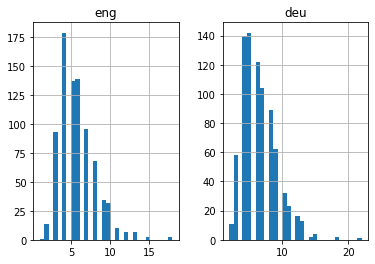

In [11]:
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [12]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [13]:
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 1050


In [14]:
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 1021


In [15]:
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [16]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [17]:
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [18]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [19]:
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [20]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [21]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
1/2 [==============>...............] - ETA: 10s - loss: 6.9560
Epoch 1: val_loss improved from inf to 5.61794, saving model to model.h1.24_jan_19


2/2 [==============================] - 24s 14s/step - loss: 6.9541 - val_loss: 5.6179
Epoch 2/30
1/2 [==============>...............] - ETA: 0s - loss: 5.6689
Epoch 2: val_loss improved from 5.61794 to 4.96201, saving model to model.h1.24_jan_19


2/2 [==============================] - 13s 13s/step - loss: 5.6796 - val_loss: 4.9620
Epoch 3/30
1/2 [==============>...............] - ETA: 0s - loss: 4.9068
Epoch 3: val_loss improved from 4.96201 to 4.76117, saving model to model.h1.24_jan_19


2/2 [==============================] - 12s 12s/step - loss: 4.9070 - val_loss: 4.7612
Epoch 4/30
1/2 [==============>...............] - ETA: 0s - loss: 4.6780
Epoch 4: val_loss improved from 4.76117 to 4.64770, saving model to model.h1.24_jan_19


2/2 [==============================] - 12s 12s/step - loss: 4.6650 - val_loss: 4.6477
Epoch 5/30
1/2 [==============>...............] - ETA: 0s - loss: 4.5264
Epoch 5: val_loss did not improve from 4.64770
2/2 [==============================] - 0s 49ms/step - loss: 4.5362 - val_loss: 4.7482
Epoch 6/30
1/2 [==============>...............] - ETA: 0s - loss: 4.5848
Epoch 6: val_loss improved from 4.64770 to 4.57129, saving model to model.h1.24_jan_19


2/2 [==============================] - 12s 12s/step - loss: 4.5914 - val_loss: 4.5713
Epoch 7/30
1/2 [==============>...............] - ETA: 0s - loss: 4.3966
Epoch 7: val_loss improved from 4.57129 to 4.51439, saving model to model.h1.24_jan_19


2/2 [==============================] - 12s 12s/step - loss: 4.4056 - val_loss: 4.5144
Epoch 8/30
1/2 [==============>...............] - ETA: 0s - loss: 4.3516
Epoch 8: val_loss did not improve from 4.51439
2/2 [==============================] - 0s 43ms/step - loss: 4.3421 - val_loss: 4.5379
Epoch 9/30
1/2 [==============>...............] - ETA: 0s - loss: 4.3221
Epoch 9: val_loss did not improve from 4.51439
2/2 [==============================] - 0s 59ms/step - loss: 4.3298 - val_loss: 4.6402
Epoch 10/30
1/2 [==============>...............] - ETA: 0s - loss: 4.4147
Epoch 10: val_loss improved from 4.51439 to 4.51214, saving model to model.h1.24_jan_19


2/2 [==============================] - 12s 12s/step - loss: 4.4074 - val_loss: 4.5121
Epoch 11/30
1/2 [==============>...............] - ETA: 0s - loss: 4.2835
Epoch 11: val_loss improved from 4.51214 to 4.47934, saving model to model.h1.24_jan_19


2/2 [==============================] - 12s 12s/step - loss: 4.2730 - val_loss: 4.4793
Epoch 12/30
1/2 [==============>...............] - ETA: 0s - loss: 4.2143
Epoch 12: val_loss did not improve from 4.47934
2/2 [==============================] - 0s 42ms/step - loss: 4.2126 - val_loss: 4.5463
Epoch 13/30
1/2 [==============>...............] - ETA: 0s - loss: 4.2608
Epoch 13: val_loss improved from 4.47934 to 4.45628, saving model to model.h1.24_jan_19


2/2 [==============================] - 13s 13s/step - loss: 4.2718 - val_loss: 4.4563
Epoch 14/30
1/2 [==============>...............] - ETA: 0s - loss: 4.1397
Epoch 14: val_loss improved from 4.45628 to 4.44301, saving model to model.h1.24_jan_19


2/2 [==============================] - 12s 12s/step - loss: 4.1517 - val_loss: 4.4430
Epoch 15/30
1/2 [==============>...............] - ETA: 0s - loss: 4.1261
Epoch 15: val_loss improved from 4.44301 to 4.43881, saving model to model.h1.24_jan_19


2/2 [==============================] - 12s 12s/step - loss: 4.1162 - val_loss: 4.4388
Epoch 16/30
1/2 [==============>...............] - ETA: 0s - loss: 4.0977
Epoch 16: val_loss did not improve from 4.43881
2/2 [==============================] - 0s 40ms/step - loss: 4.1049 - val_loss: 4.8607
Epoch 17/30
1/2 [==============>...............] - ETA: 0s - loss: 4.5588
Epoch 17: val_loss did not improve from 4.43881
2/2 [==============================] - 0s 40ms/step - loss: 4.5339 - val_loss: 4.5044
Epoch 18/30
1/2 [==============>...............] - ETA: 0s - loss: 4.1097
Epoch 18: val_loss improved from 4.43881 to 4.42738, saving model to model.h1.24_jan_19


2/2 [==============================] - 12s 12s/step - loss: 4.1014 - val_loss: 4.4274
Epoch 19/30
1/2 [==============>...............] - ETA: 0s - loss: 4.0142
Epoch 19: val_loss did not improve from 4.42738
2/2 [==============================] - 0s 39ms/step - loss: 4.0334 - val_loss: 4.4460
Epoch 20/30
1/2 [==============>...............] - ETA: 0s - loss: 4.0482
Epoch 20: val_loss did not improve from 4.42738
2/2 [==============================] - 0s 41ms/step - loss: 4.0636 - val_loss: 4.5681
Epoch 21/30
1/2 [==============>...............] - ETA: 0s - loss: 4.2059
Epoch 21: val_loss did not improve from 4.42738
2/2 [==============================] - 0s 44ms/step - loss: 4.2033 - val_loss: 4.4768
Epoch 22/30
1/2 [==============>...............] - ETA: 0s - loss: 4.0119
Epoch 22: val_loss improved from 4.42738 to 4.36855, saving model to model.h1.24_jan_19


2/2 [==============================] - 13s 13s/step - loss: 4.0261 - val_loss: 4.3686
Epoch 23/30
1/2 [==============>...............] - ETA: 0s - loss: 3.9411
Epoch 23: val_loss did not improve from 4.36855
2/2 [==============================] - 0s 43ms/step - loss: 3.9534 - val_loss: 4.3814
Epoch 24/30
1/2 [==============>...............] - ETA: 0s - loss: 3.9388
Epoch 24: val_loss did not improve from 4.36855
2/2 [==============================] - 0s 42ms/step - loss: 3.9376 - val_loss: 4.5321
Epoch 25/30
1/2 [==============>...............] - ETA: 0s - loss: 4.1151
Epoch 25: val_loss did not improve from 4.36855
2/2 [==============================] - 0s 37ms/step - loss: 4.1127 - val_loss: 4.4231
Epoch 26/30
1/2 [==============>...............] - ETA: 0s - loss: 3.9292
Epoch 26: val_loss did not improve from 4.36855
2/2 [==============================] - 0s 43ms/step - loss: 3.9219 - val_loss: 4.5813
Epoch 27/30
1/2 [==============>...............] - ETA: 0s - loss: 4.0464
Epoch 27

2/2 [==============================] - 12s 12s/step - loss: 3.9659 - val_loss: 4.3261
Epoch 29/30
1/2 [==============>...............] - ETA: 0s - loss: 3.8236
Epoch 29: val_loss did not improve from 4.32613
2/2 [==============================] - 0s 40ms/step - loss: 3.8242 - val_loss: 4.3334
Epoch 30/30
1/2 [==============>...............] - ETA: 0s - loss: 3.7977
Epoch 30: val_loss did not improve from 4.32613
2/2 [==============================] - 0s 39ms/step - loss: 3.7905 - val_loss: 4.3460


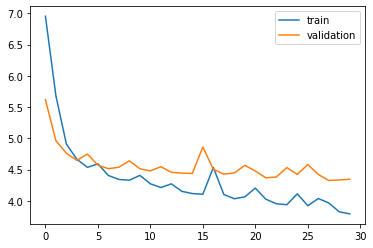

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [25]:
model = load_model('model.h1.24_jan_19')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))

6/6 [==============================] - 1s 6ms/step
